# Classification and Clustering Using BERT


---



---

**Authors**: This a product of the joint efforts of Niti, Sola & Mohamed


## 1. Classification

In [ ]:
# general imports
import io
import os
import json
from collections import Counter

# nlp imports
import string
import re
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install Emote
import emote

# matplotlib, pandas and numpy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np

# sklearn imports
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# TF imports
# !pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import text as textprocessor
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
# !pip install tensorflow_addons
import tensorflow_addons as tfa

In [2]:
# map contractions to their composite words, import accompanying contractions files
with open("contractions.json", "r") as contractions:
    new_words_dict = json.load(contractions) 

def process_tweet(tweet, stopwrds = False, convert_emojis=False):

    tweet = str(tweet).replace("\n", " ")
    tokenized_tweet = tweet.split(" ")

    mod_tweet = []
    for token in tokenized_tweet:
        token = ' ' if "@" in token else token                           # remove user
        token = token[1:] if '#' in token else token                     # remove hashtag and keep as token
        token = token.replace("\n"," ") if '\n' in token else token  
        token = 'URL' if ('http' or 'https') in token else token         # replace links with string URL 
        token = token.replace("’", "'")  if "’"  in token else token     # correct encoding # remove 's from end of tokens
        token = token[:-2] if token.endswith("'s") else token            # remove possessive suffix from end of tokens
        mod_tweet.append(token)
        
    
    mod_tweet = [new_words_dict[token] if token in new_words_dict else token for token in mod_tweet] # whole world filter

    if stopwrds: # use cautiously
        mod_tweet = [" " if token in stopwords.words('english') else token for token in mod_tweet]

    mod_tweet = " ".join(mod_tweet)                                                 # join tokens
    mod_tweet = re.sub(r'(?<=\w)[^\s\w](?![^\s\w])', '', mod_tweet)                 # remove punctuation
    
    # if you're corpus contains emojis
    if convert_emojis:
        for char in range(len(mod_tweet)):
            try:
                mod_tweet.replace(mod_tweet[char], emote.decode(mod_tweet[char]))
            except: pass


    return mod_tweet

#### Preprocessing Data

In [3]:
# use a DataFrame to load the data for ease of use

df = pd.read_csv("hs_train.csv")
df.drop(columns=["id"], inplace=True)

# if in a json use:
# tweets = []
# for line in open('all_tweets.json', 'r'):
#     tweets.append(json.loads(line))
# x, y = [], []
# for i in tweets:
#     x.append(i['full_tweet']), y.append(i['label']) # change full_tweet, label to the respective keys of your json
# df = pd.DataFrame()
# df["Tweets"], df["Labels"] = x, y

# encode labels if you're labels are in string format
# le = preprocessing.LabelEncoder()
# le.fit(df["Labels"])
# y = le.transform(df["Labels"])
# df["Labels"] = y
# Counter(y)

x, y = df.tweet, df.label

x.apply(process_tweet)
# train-test split if you're data isnt' split
# x=df["Tweets"] # relevant for classification and clustering
# y=df["Labels"] # onlt relevant for classification
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.2) # stratify (ensures split according to class balance) added NM

pd.set_option('max_colwidth', 800)
x_test.head(5)

11184                                   pinned to instagood on @user hilarious! - at least it's just icecream!   
30066                  â¦you #black &amp; feel like the  are stomping on you? listen  #retweet #tampa #miamiâ¦ 
20641     @user body...temple.... bsð . . . . . #body #instagood #love #life #temple #pic #photooftheday  â¦ 
951                                                                @user i had a little taste it was   for sure! 
22765                   #parndorf is an #amazing place with even a #secret #ocean #austria #viena   #dinneimeâ¦ 
Name: tweet, dtype: object

In [ ]:
# apply GloVe specific preprocessing (Niti)
MAX_WORDS = None                                              # Max no. of words we want for each tweet
MAX_SEQUENCE_LENGTH = x_train.apply(lambda x: len(x)).max()   # Max no. of words in a tweet within the corpus

tokenizer = textprocessor.Tokenizer(num_words = MAX_WORDS)    # tokenize each tweet with input sequence length as max_words and get indicies 
tokenizer.fit_on_texts(x_train)                               # create vocabulary by fitting on train set 
# tokenizer.fit_on_texts(df['Tweets'])                        # create vocabulary by fitting on entire data set 
word_index = tokenizer.word_index

xtrain_seq = tokenizer.texts_to_sequences(x_train)            # transform train and test set index above
xtest_seq = tokenizer.texts_to_sequences(x_test)

# pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=MAX_SEQUENCE_LENGTH) # ensure input sequences have the same length
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=MAX_SEQUENCE_LENGTH)

# y_train, y_test = tf.convert_to_tensor(y_train, np.float32), tf.convert_to_tensor(y_test, np.float32)

print(xtrain_pad.shape, xtest_pad.shape)
print(y_train.shape, y_test.shape)

(25569, 274) (6393, 274)
(25569,) (6393,)


#### Generate GloVe Embedding Matrix

In [ ]:
# download GloVe pretrained vectors: https://nlp.stanford.edu/projects/glove/ for twitter data of dimension size 200

embedpath = ""
EMBEDDING_DIM = 200                                                    # dim of glove embedding vectors
GLOVE_DIR = embedpath+"glove.twitter.27B."+str(EMBEDDING_DIM)+"d.txt"

embedding_vectors = {}
with io.open(GLOVE_DIR, encoding='utf8') as file:
    for row in file:
        values = row.split(' ')                                  # split each item in a row
        word = values[0]                                         # word is the first item 
        weights = np.asarray([float(val) for val in values[1:]]) # weights are second item onwards
        embedding_vectors[word] = weights                        # dictionary of word and its weights
print(f"Size of GloVe vocabulary: {len(embedding_vectors)}")   

Size of GloVe vocabulary: 1193515


In [ ]:
# create embedding matrix based based on words from the corpus
if MAX_WORDS is not None:           
    vocab_len = MAX_WORDS            
else:
    vocab_len = len(word_index)+1                        # use vocab size of the corpus or pre-defined number

embedding_matrix = np.zeros((vocab_len, EMBEDDING_DIM))  # initialize the embedding_matrix with zeros
new_words_count = 0
new_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)   # get the embedding vector for each word
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:                                            # track words that doesn't exist 
            new_words_count += 1 
            new_words.append(word)

print(f'{new_words_count} out of {vocab_len} words were OOV.') # count of out of vocabulary words
print(f'Some out of vocabulary words: {new_words[:10]}')            # print some of the out of vocabulary words

17985 out of 39738 words were OOV.
Some out of vocabulary words: ['â\x80¦', "it's", "i'm", 'bihday', "can't", "don't", '2', '3', "father's", '1']


#### Train/Validate

In [ ]:
BATCH_SIZE = 256
EPOCHS  = 25
METRICS = [
#            tfa.metrics.F1Score(average='weighted', num_classes=2, name="Weighted-F1"),
           tf.keras.metrics.AUC(num_thresholds=5, name = "Area_under_the_curve"),
#            tf.keras.metrics.BinaryAccuracy()
           ]
REG_NODES = [60, 50]
ACTIVATION = ["relu", "tanh"] #LeakyReLU(alpha=0.01)
OPTIMIZER = "adam" #tf.keras.optimizers.Adam(learning_rate=0.01)
ES = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, mode="min", verbose=1)

In [ ]:
def glove_classifier_model(lstm=False, regularizer=True):

    # initialize input sequence and add embedding layer
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(vocab_len,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            name = 'embeddings')
    embedded_sequences = embedding_layer(sequence_input)

    if lstm:
        x = LSTM(LAYERS[0], return_sequences=True, name='lstm_layer', recurrent_dropout=0.4)(embedded_sequences) # bidirectional did not perform well with LSTM
    else:
        x = Bidirectional(GRU(LAYERS[0], return_sequences=True))(embedded_sequences)

    # add additional layers
    x = GlobalMaxPool1D()(x)
    # x = Dropout(0.5)(x) # to avoid overfitting try using dropout after dense layer only not after maxpool layers

    if regularizer:
        x = Dense(LAYERS[1], activation=ACTIVATION, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(x)
    else:
        x = Dense(LAYERS[1], activation=ACTIVATION)(x)

    x = Dropout(0.5)(x)
    preds = Dense(1, activation="sigmoid")(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=METRICS)
    return model

Epoch 1/25
100/100 [==============================] - 6s 39ms/step - loss: 0.6922 - Area_under_the_curve: 0.6412 - val_loss: 0.3886 - val_Area_under_the_curve: 0.7573
Epoch 2/25
100/100 [==============================] - 4s 35ms/step - loss: 0.2976 - Area_under_the_curve: 0.8000 - val_loss: 0.2205 - val_Area_under_the_curve: 0.7887
Epoch 3/25
100/100 [==============================] - 4s 35ms/step - loss: 0.1962 - Area_under_the_curve: 0.8285 - val_loss: 0.1706 - val_Area_under_the_curve: 0.7968
Epoch 4/25
100/100 [==============================] - 4s 36ms/step - loss: 0.1603 - Area_under_the_curve: 0.8375 - val_loss: 0.1493 - val_Area_under_the_curve: 0.8197
Epoch 5/25
100/100 [==============================] - 4s 36ms/step - loss: 0.1428 - Area_under_the_curve: 0.8556 - val_loss: 0.1392 - val_Area_under_the_curve: 0.8458
Epoch 6/25
100/100 [==============================] - 4s 36ms/step - loss: 0.1292 - Area_under_the_curve: 0.8704 - val_loss: 0.1346 - val_Area_under_the_curve: 0.831

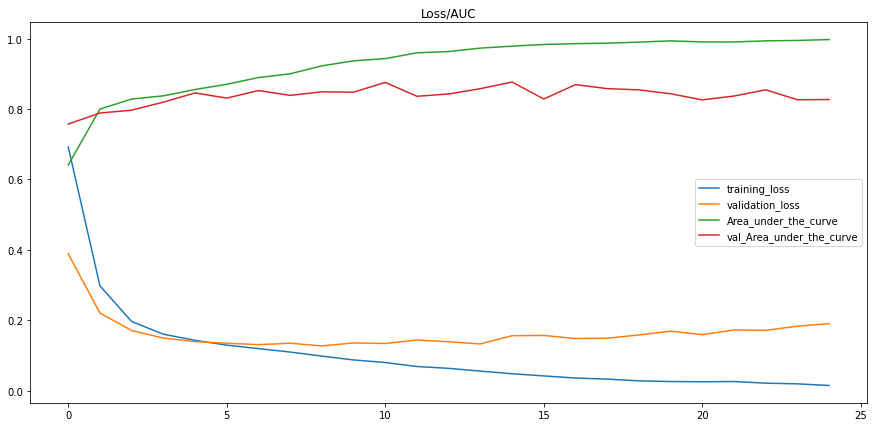

In [ ]:

# train
gru_model = glove_classifier_model(lstm=False, regularizer=True)
gru_history = gru_model.fit(xtrain_pad, y_train, validation_data=(xtest_pad, y_test), 
                              batch_size = BATCH_SIZE, epochs = EPOCHS,
                              # , callbacks = [ES]
                            )
# evaluate
gru_loss, gru_auc = gru_model.evaluate(xtest_pad, y_test, verbose=0)
print(f"model loss: {gru_loss}")
print(f"model AUC: {gru_auc}")

# plot AUC and loss
plt.figure(figsize=(15, 7))
plt.plot(range(EPOCHS), gru_history.history['loss'])
plt.plot(range(EPOCHS), gru_history.history['val_loss'])
plt.plot(range(EPOCHS), gru_history.history['Area_under_the_curve'])
plt.plot(range(EPOCHS), gru_history.history['val_Area_under_the_curve'])
plt.legend(['training_loss', 'validation_loss', 'Area_under_the_curve', 'val_Area_under_the_curve'])
plt.title('Loss/AUC')
plt.show()

Epoch 1/25
100/100 [==============================] - 5s 38ms/step - loss: 0.2246 - Area_under_the_curve: 0.6743 - val_loss: 0.1494 - val_Area_under_the_curve: 0.7905
Epoch 2/25
100/100 [==============================] - 3s 33ms/step - loss: 0.1480 - Area_under_the_curve: 0.8229 - val_loss: 0.1316 - val_Area_under_the_curve: 0.8352
Epoch 3/25
100/100 [==============================] - 3s 33ms/step - loss: 0.1283 - Area_under_the_curve: 0.8464 - val_loss: 0.1217 - val_Area_under_the_curve: 0.8336
Epoch 4/25
100/100 [==============================] - 3s 33ms/step - loss: 0.1125 - Area_under_the_curve: 0.8773 - val_loss: 0.1152 - val_Area_under_the_curve: 0.8596
Epoch 5/25
100/100 [==============================] - 3s 33ms/step - loss: 0.0968 - Area_under_the_curve: 0.8981 - val_loss: 0.1103 - val_Area_under_the_curve: 0.8762
Epoch 6/25
100/100 [==============================] - 3s 33ms/step - loss: 0.0813 - Area_under_the_curve: 0.9248 - val_loss: 0.1158 - val_Area_under_the_curve: 0.838

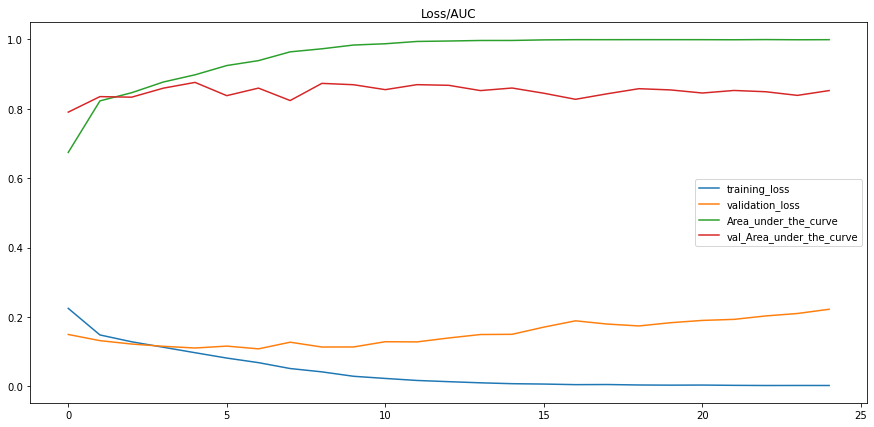

In [ ]:
# train
gru_model = glove_classifier_model(lstm=False, regularizer=False)
gru_history = gru_model.fit(xtrain_pad, y_train, validation_data=(xtest_pad, y_test), 
                              batch_size = BATCH_SIZE, epochs = EPOCHS,
                              # , callbacks = [ES]
                            )
# evaluate
gru_loss, gru_auc = gru_model.evaluate(xtest_pad, y_test, verbose=0)
print(f"model loss: {gru_loss}")
print(f"model AUC: {gru_auc}")

# plot AUC and loss
plt.figure(figsize=(15, 7))
plt.plot(range(EPOCHS), gru_history.history['loss'])
plt.plot(range(EPOCHS), gru_history.history['val_loss'])
plt.plot(range(EPOCHS), gru_history.history['Area_under_the_curve'])
plt.plot(range(EPOCHS), gru_history.history['val_Area_under_the_curve'])
plt.legend(['training_loss', 'validation_loss', 'Area_under_the_curve', 'val_Area_under_the_curve'])
plt.title('Loss/AUC')
plt.show()

model loss: 0.1808716356754303
model AUC: 0.7828744649887085


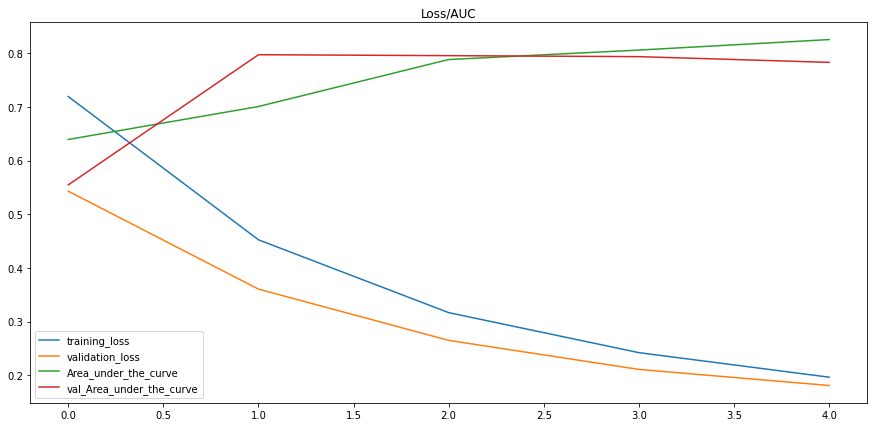

In [ ]:
# with processing function applied
# & tokens based on training dataset only

# # train
# lstm_model = glove_classifier_model(lstm=True, regularizer=True) #regularization applied
# lstm_history = lstm_model.fit(xtrain_pad, y_train, validation_data=(xtest_pad, y_test), 
#                               batch_size = 512, epochs = 5,
#                               # , callbacks = [ES]
#                             )

# evaluation on brand new test set, which is named validation set in this program
# lstm_loss, lstm_auc = lstm_model.evaluate(xtest_pad, y_test, verbose=0)
print(f"model loss: {lstm_loss}")
print(f"model AUC: {lstm_auc}")

# plot AUC and loss
plt.figure(figsize=(15, 7))
plt.plot(range(5), lstm_history.history['loss'])
plt.plot(range(5), lstm_history.history['val_loss'])
plt.plot(range(5), lstm_history.history['Area_under_the_curve'])
plt.plot(range(5), lstm_history.history['val_Area_under_the_curve'])
plt.legend(['training_loss', 'validation_loss', 'Area_under_the_curve', 'val_Area_under_the_curve'])
plt.title('Loss/AUC')
plt.show()

#### Evaluate

In [ ]:
gru_pred = gru_model.predict(xtest_pad)
predictions_df = y_test.to_frame()
predictions_df['Predictions'] = (gru_pred > 0.5)*1
predictions_df['Tweets'] = x_test
predictions_df.style.set_properties(**{'text-align': 'right'})
predictions_df.head()

,label,Predictions,Tweets
6990,0,0,@user a special weekend delivery for a very happy complete material handling customer. #forklift
2589,0,0,when you feel like a boss ððªð¼ð #bossmode #health #nutrition #fitness #hiittraining â¦
21465,0,0,how to get balance in my life no4 #balance #dam #travel #smile #thailand @user
433,0,0,@user * sweets ð°ð©ð¬ð­ð«â¨!!!!!! * #instagood #ìì´ë #å¶å #idola #idol #à¹à¸­à¸à¸­à¸¥ #followme #selfie #ã©ãããâ¦
25134,0,0,you only talk to me when no one is around. #depression #mad


In [ ]:
cr = classification_report(predictions_df.label, predictions_df.Predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5945
           1       0.79      0.68      0.73       448

    accuracy                           0.97      6393
   macro avg       0.88      0.83      0.86      6393
weighted avg       0.96      0.97      0.96      6393



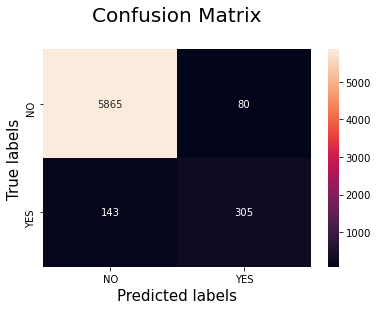

In [ ]:
import seaborn as sns
# calculate confusion matrix and plot it
cm = confusion_matrix(predictions_df.label, predictions_df.Predictions, labels=[0,1])    

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels', fontsize=15)
ax.set_ylabel('True labels', fontsize=15)
ax.set_title('Confusion Matrix\n', fontsize=20)
ax.xaxis.set_ticklabels(['NO', 'YES']); ax.yaxis.set_ticklabels(['NO', 'YES'])
plt.show()

In [ ]:
incorrect_predictions = predictions_df[predictions_df.label !=predictions_df.Predictions]
correct_predictions = predictions_df[predictions_df.label ==predictions_df.Predictions]

true_positives = correct_predictions[(correct_predictions['label']==1)]
true_negatives = correct_predictions[(correct_predictions['label']==0)]

false_positives = incorrect_predictions[(incorrect_predictions['label']==0)]
false_negatives = incorrect_predictions[(incorrect_predictions['label']==1)]

In [ ]:
false_positives

,label,Predictions,Tweets
18217,0,1,nohwest albea coal town could face dissolution to deal with financial concerns via @user
9147,0,1,i have never had so much feminism fuelled anger and i have had recently #feminism #socialjustice
9885,0,1,"@user (sorry, that was meaningless.. )"
24903,0,1,@user @user bihday dear lady
21840,0,1,people are ignorant...... #dobetter
...,...,...,...
7562,0,1,#itveuref turkey is coming into the european union you moron.
11116,0,1,#retropic bihday nick rhodes (1980s) #dh #history via /r/#oldschoolcool
16330,0,1,ablonde a #hot east european #woman ready for you i love to please man and make them !
615,0,1,haunting atmospherics #studiotime


In [ ]:
false_negatives

,label,Predictions,Tweets
692,1,0,"carolyn cooper | ugly, poor, ignorant and black!"
31926,1,0,a follow up from the gentlemen who were kicked off of @user airlines for simply speaking arabic
7113,1,0,@user i can't believe you keep a like @user as your spokesperson. what a loser company you are.
17689,1,0,"#joemixon #espn #minnesotavikings, and it ""goes without saying"", he's a #homophobe, too. #sucklahoma #oabâ¦"
24715,1,0,@user @user coming from and #powerhungrytraitors. the #hereticfoundation!
...,...,...,...
7768,1,0,the scars left by us waime camps mt @user
23208,1,0,@user i'm genuinely disappointed that a performer as great as @user is judged in 2016 for having hair under heâ¦
4632,1,0,how was first officially codified in 15th-century #spain
5823,1,0,freaking nasty rotten people #whiteslavers monsters release domÃ©nica now #whiteslavery #venezuela you are going to pay. let her free


### BERT

Trying classification with a small BERT architecture from TensorFlow Hub

#### Installs and imports

In [ ]:
# !pip3 install -q -U tensorflow-text
# !pip3 install -q -U tf-models-official

# Other TF imports
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

# Setting up spacy SBERT depencies: spacy transformer and spacy sentence bert
!python -m pip install --upgrade pip --quiet
!pip3 install spacy --quiet
!pip3 install spacy-transformers --quiet
!pip3 install spacy_sentence_bert

import spacy
import spacy_transformers
import spacy_sentence_bert

# NLP imports - NLTK KMeans Clusterer
from nltk.cluster import KMeansClusterer

In [8]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

In [ ]:
# setup train/test datasets for classification (clustering clustering will only use x as in df["Tweets"])
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


# setup batches for text embedders/encoders + classifier

SHUFFLE_BUFFER_SIZE = 100

train_ds = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE//2).batch(BATCH_SIZE)

In [ ]:
BATCH_SIZE = 128

####  A) Tensorflow hub architectures

In [ ]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-256_A-4' # change to desired configuration

tfhub_handle_encoder = map_name_to_handle[bert_model_name] # map to chosen encoder configuration
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name] # map to chosen encoder configuration


In [ ]:
import keras.backend as K
import tensorflow_addons as tfa

def build_classifier_model():
    '''
    This function builds a text classifier model
    '''
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Tweets') # takes on any shape input
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='Preporcessing') # BERT preprocessing layer
    encoder_inputs = preprocessing_layer(text_input) # BERT encoding layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='Encoding')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] # using pooled output since it is sufficient for predictive purposes

    # Where actual classifier layers start
    net = tf.keras.layers.Dropout(0.1)(net) # dropout optimal at 0.1, anything more or less overfits
    # Add dense layers as required. For optimal model, no intermediate dense layers are added
    net = tf.keras.layers.Dense(2, activation="softmax", name='Classifier')(net) # only one dense output layer is optimal, any other layers overfit
    return tf.keras.Model(text_input, net)


# Loss, metrics and optimizer

loss= tf.keras.losses.CategoricalCrossentropy()
metrics = [
           tfa.metrics.F1Score(average='weighted', num_classes=2, name="Weighted-F1"),
           tf.keras.metrics.AUC(num_thresholds=5, name = "Area_under_the_curve"),
           tf.keras.metrics.BinaryAccuracy()
           ]


# optimzer
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
# warm up steps help reduce large effects of the initial few training instances
num_warmup_steps = int(0.1*num_train_steps) 

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          # adamw uses a regularization parameter making it better than adam
                                          optimizer_type='adamw')
# instantiate compile
classifier_model = build_classifier_model()

# compile model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Summarize/plot model

In [ ]:
# tf.keras.utils.plot_model(classifier_model) 
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tweets (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 Preporcessing (KerasLayer)     {'input_type_ids':   0           ['Tweets[0][0]']                 
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

##### Train/Validate

In [ ]:
classifier_model.fit(train_ds, validation_data=test_ds, epochs=5, batch_size=128)

Epoch 1/5
800/800 [==============================] - 235s 284ms/step - loss: 0.1880 - Weighted-F1: 0.9283 - Area_under_the_curve: 0.9541 - binary_accuracy: 0.9392 - val_loss: 0.1196 - val_Weighted-F1: 0.9549 - val_Area_under_the_curve: 0.9721 - val_binary_accuracy: 0.9571
Epoch 2/5
800/800 [==============================] - 227s 283ms/step - loss: 0.1133 - Weighted-F1: 0.9593 - Area_under_the_curve: 0.9736 - binary_accuracy: 0.9618 - val_loss: 0.1165 - val_Weighted-F1: 0.9599 - val_Area_under_the_curve: 0.9722 - val_binary_accuracy: 0.9604
Epoch 3/5
800/800 [==============================] - 225s 282ms/step - loss: 0.0885 - Weighted-F1: 0.9687 - Area_under_the_curve: 0.9787 - binary_accuracy: 0.9700 - val_loss: 0.1285 - val_Weighted-F1: 0.9621 - val_Area_under_the_curve: 0.9715 - val_binary_accuracy: 0.9631
Epoch 4/5
800/800 [==============================] - 225s 281ms/step - loss: 0.0721 - Weighted-F1: 0.9757 - Area_under_the_curve: 0.9837 - binary_accuracy: 0.9765 - val_loss: 0.1369

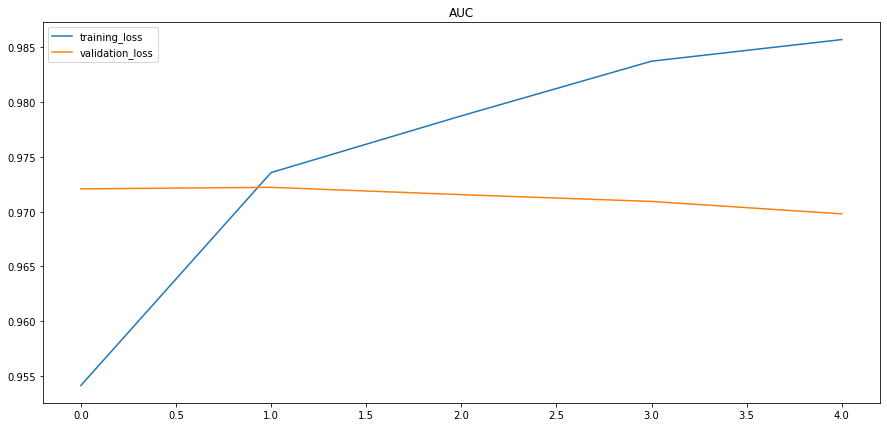

In [ ]:
# plot AUC and loss
plt.figure(figsize=(15, 7))
plt.plot(range(5), classifier_model.history.history['Area_under_the_curve'])
plt.plot(range(5), classifier_model.history.history['val_Area_under_the_curve'])
plt.legend(['training_loss', 'validation_loss', 'Area_under_the_curve', 'val_Area_under_the_curve'])
plt.title('AUC')
plt.show()

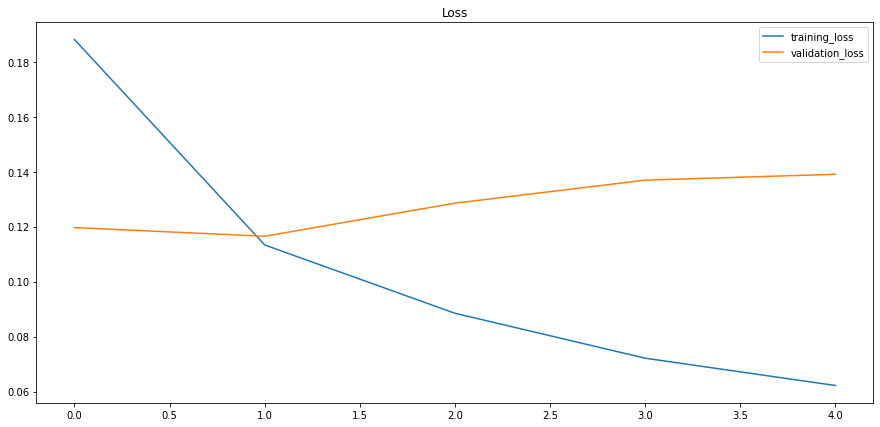

In [ ]:
# plot AUC and loss
plt.figure(figsize=(15, 7))
plt.plot(range(5), classifier_model.history.history['loss'])
plt.plot(range(5), classifier_model.history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')
plt.show()

#### B) Sentence transformers library - pretrained sentence BERTs

In [5]:
# Create unique train dataset for sentence_transformers which is a list of sentences

train_dataset_SF = [i for i in df.tweet.apply(process_tweet)]
train_dataset_SF[:5]

['   when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run',
 '    thanks for lyft credit i cannot use cause they do not offer wheelchair vans in pdx    disapointed getthanked',
 '  bihday your majesty',
 'model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide society now    motivation']

Import and setup pre-trained models

In [ ]:
from sentence_transformers import SentenceTransformer, LoggingHandler
import logging

#### Just some code to print debug information to stdout
np.set_printoptions(threshold=100)

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

#### /print debug information to stdout

# Load pre-trained Sentence Transformer Model. It will be downloaded automatically
model = SentenceTransformer('all-mpnet-base-v2')
# Others architechtures that we've tested: 'all-distilroberta-v1', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', 'all-MiniLM-L6-v2'

# Embed a list of sentences
sentence_embeddings = model.encode(train_dataset_SF)

# Define shape for the output
shape = (sentence_embeddings[:5].shape)[1]

Setup batches and classifier for classification using the above SBERT encodings

In [10]:
x=sentence_embeddings
y=np.array(df.label)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle=True)

y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)

# setup train/test datasets for classification
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_data = train_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_data = test_data.shuffle(SHUFFLE_BUFFER_SIZE//2).batch(BATCH_SIZE)

In [16]:
def build_classifier_model_st():
  '''
  Basic classification layers that takes in shape equal to the defined encoding size of SBERT
  '''
  text_input = tf.keras.layers.Input(shape=shape, name='Tweets')
  net = tf.keras.layers.Dropout(0.1)(text_input)
  # Add dense layers as necessary
  net = tf.keras.layers.Dense(32, activation="relu", name='Dense1')(net)
  net = tf.keras.layers.Dense(2, activation="softmax", name='Classifier')(net) 
  return tf.keras.Model(text_input, net)


metrics = [tfa.metrics.F1Score(average='weighted', num_classes=2, name="Weighted-F1"),
           tf.keras.metrics.AUC(num_thresholds=5, name = "Area_under_the_curve"),
           tf.keras.metrics.BinaryAccuracy()]
loss= tf.keras.losses.CategoricalCrossentropy()

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
# warm up steps help reduce large effects of the initial few training instances
num_warmup_steps = int(0.1*num_train_steps) 

# Learning rates: optinal and stable at 0.004/0.005, anything above or below has either not converged or was too unstable during training 
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          # adamw uses a regularization parameter making it better than adam
                                          optimizer_type='adamw')

classifier_model_st = build_classifier_model_st()

# compile model
classifier_model_st.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics) 

2021-12-14 18:14:30 - using Adamw optimizer
2021-12-14 18:14:30 - gradient_clip_norm=1.000000


##### Train/Validate

In [17]:
classifier_model_st.fit(train_data, batch_size=64, epochs=10, validation_data=test_data)

Epoch 1/10
335/335 [==============================] - 4s 9ms/step - loss: 0.6239 - Weighted-F1: 0.8914 - Area_under_the_curve: 0.9070 - binary_accuracy: 0.9070 - val_loss: 0.5572 - val_Weighted-F1: 0.9013 - val_Area_under_the_curve: 0.9324 - val_binary_accuracy: 0.9324
Epoch 2/10
335/335 [==============================] - 3s 8ms/step - loss: 0.4783 - Weighted-F1: 0.8937 - Area_under_the_curve: 0.9305 - binary_accuracy: 0.9279 - val_loss: 0.4065 - val_Weighted-F1: 0.9012 - val_Area_under_the_curve: 0.9465 - val_binary_accuracy: 0.9333
Epoch 3/10
335/335 [==============================] - 3s 8ms/step - loss: 0.3662 - Weighted-F1: 0.8934 - Area_under_the_curve: 0.9554 - binary_accuracy: 0.9280 - val_loss: 0.3244 - val_Weighted-F1: 0.9013 - val_Area_under_the_curve: 0.9665 - val_binary_accuracy: 0.9334
Epoch 4/10
335/335 [==============================] - 3s 8ms/step - loss: 0.3054 - Weighted-F1: 0.8934 - Area_under_the_curve: 0.9636 - binary_accuracy: 0.9280 - val_loss: 0.2791 - val_Weigh

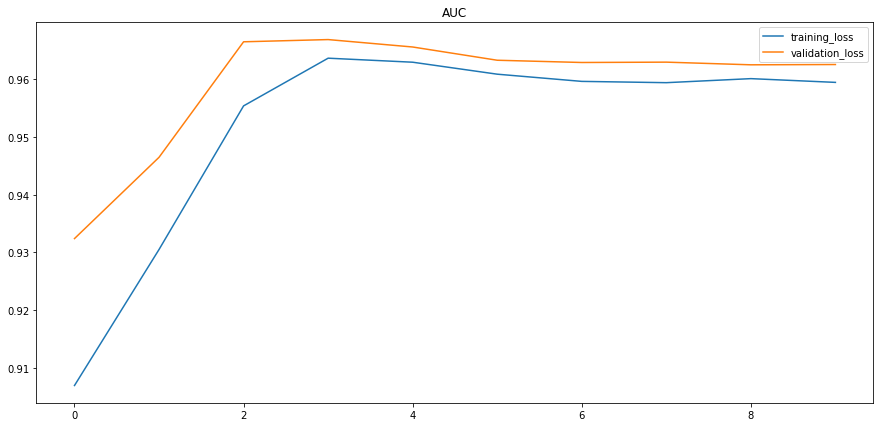

In [19]:
# plot AUC and loss
plt.figure(figsize=(15, 7))
plt.plot(range(10), classifier_model_st.history.history['Area_under_the_curve'])
plt.plot(range(10), classifier_model_st.history.history['val_Area_under_the_curve'])
plt.legend(['training_loss', 'validation_loss', 'Area_under_the_curve', 'val_Area_under_the_curve'])
plt.title('AUC')
plt.show()

##### Evaluate

In [33]:
sbert_loss, sbert_F1, sbert_auc, sbert_acc = classifier_model_st.evaluate(x_test, y_test, verbose=0)
print(f"model loss: {sbert_loss}")
print(f"model AUC: {sbert_auc}")

model loss: 0.21288076043128967
model AUC: 0.9625244736671448


## Appendix 1 (BERT configurations - TF Hub)

In [ ]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}
